In [1]:
#Install all dependencies
!pip install utils obspy

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 64.3 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.7 MB/s eta 0:00:00:00:01
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=2604fa8e9e03b0bc3d21a8ec575967e0295832692654e817bbc0c5a298aff9fe
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.36
    Uninstalling SQLAlchemy-2.0.36:
      Successfully uninstalled SQLAlchemy-2.0.36
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.54 which is incompatible.


# IMPORTING ALL RELEVANT LIBRARIES

In [3]:
# Libraries for neural networks
import torch
import torch.nn as nn

# Libraries for data processing and analysis
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import NearestNeighbors  # For KNN implementation
# Libraries for seismic data and utilities
from obspy import read
from obspy import UTCDateTime

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Utility functions and external models (custom imports, ensure these are implemented)
from utils import *  # Ensure `utils.py` exists and contains the required functions
# from autoencoder_model import *  # Uncomment if `autoencoder_model.py` is implemented

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)  # Torch seed
np.random.seed(seed)  # NumPy seed

# Set the plotting style
plt.style.use('seaborn-v0_8-darkgrid')  # Use the latest Seaborn dark grid style
sns.set_context("talk")  # Larger font size for better visuals

In [4]:
from scipy.fftpack import fft
from scipy.signal import butter, filtfilt, get_window, welch
from scipy.stats import skew, kurtosis, entropy
import torch
from obspy import read

In [9]:
file_path="/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/mars/test/data/XB.ELYSE.02.BHV.2019-05-23HR02_evid0041.mseed"

# EXTRACTING THE FEATURES FROM TWO WAVES  

Extracted Features:
True Peak Amplitude: 1.0
True RMS Amplitude: 0.23745056932075997
Filtered Peak Amplitude: 0.2765425107159205
Filtered RMS Amplitude: 0.012506469694513016
Crest Factor: 22.111956249112286
Zero-Crossing Rate: 0.431478214975208
Skewness: -0.2440202134132675
Kurtosis: 6.2473507288285255
Dominant Frequency: 1.0
Spectral Centroid: 4.033732913923835
Bandwidth: 2.518800135820393
Total Power: 0.0020140318600377818
Peak Frequency: 4.0625
Signal Entropy: 4.216883570499353


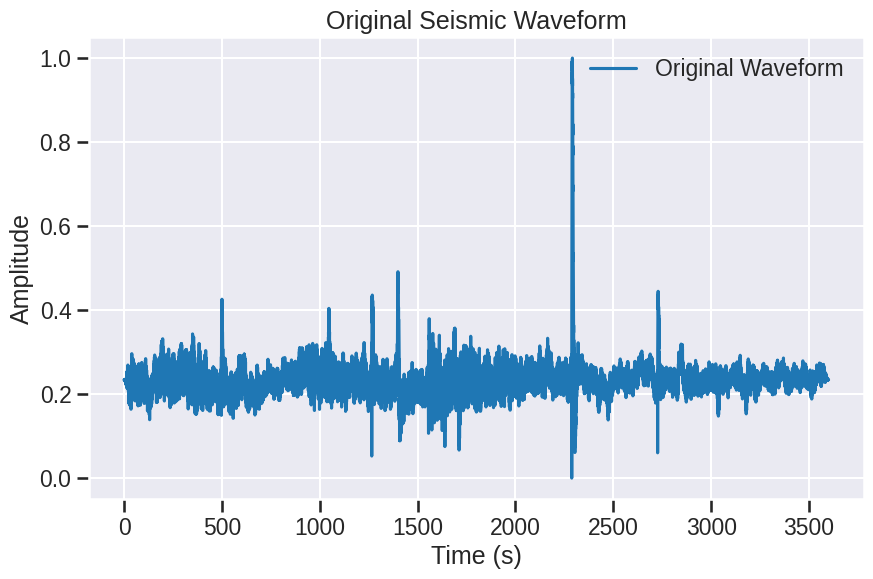

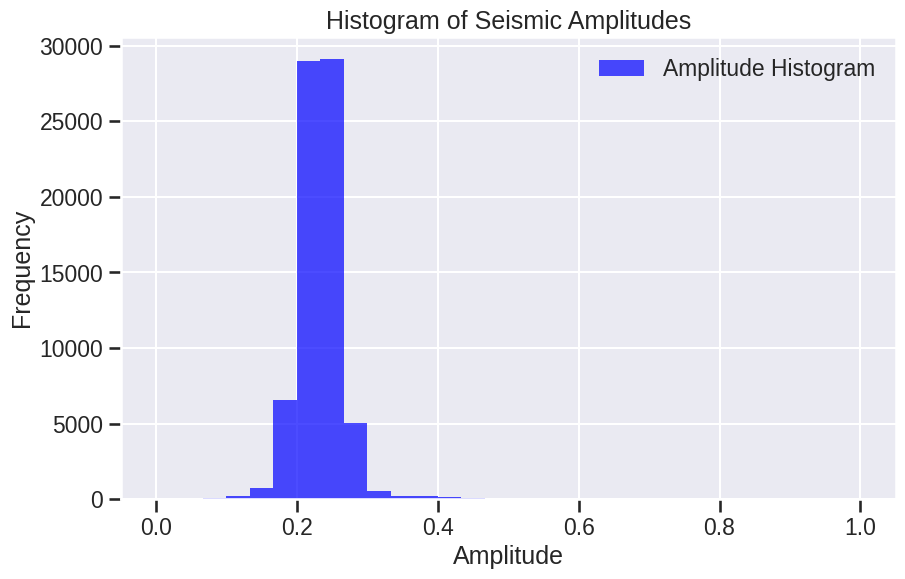

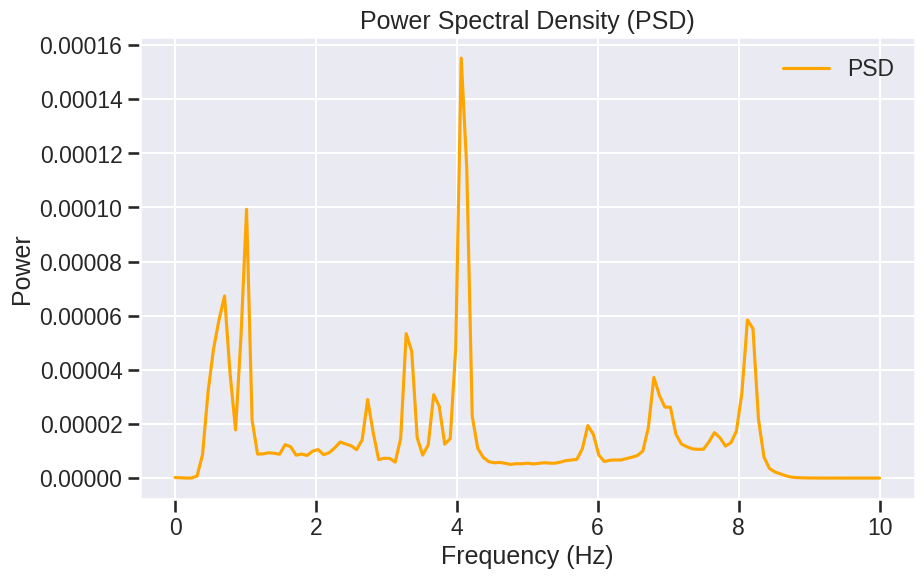

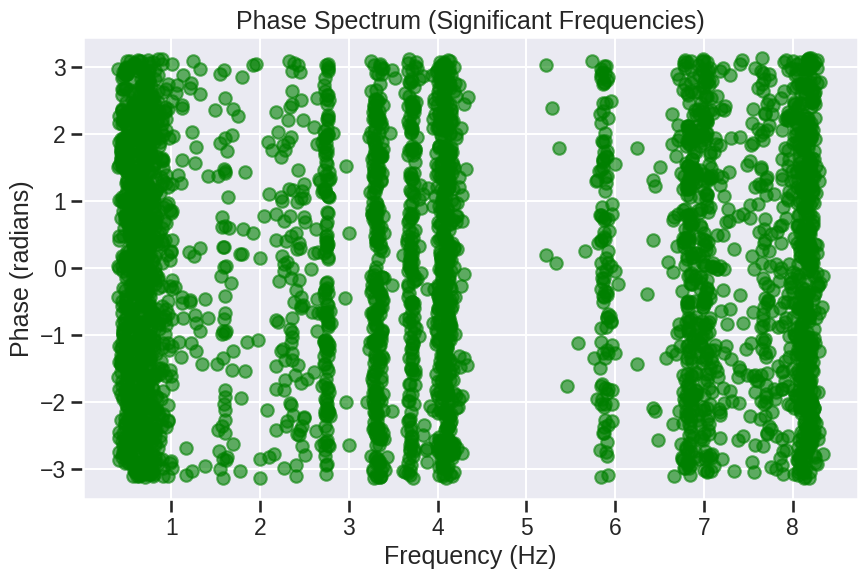

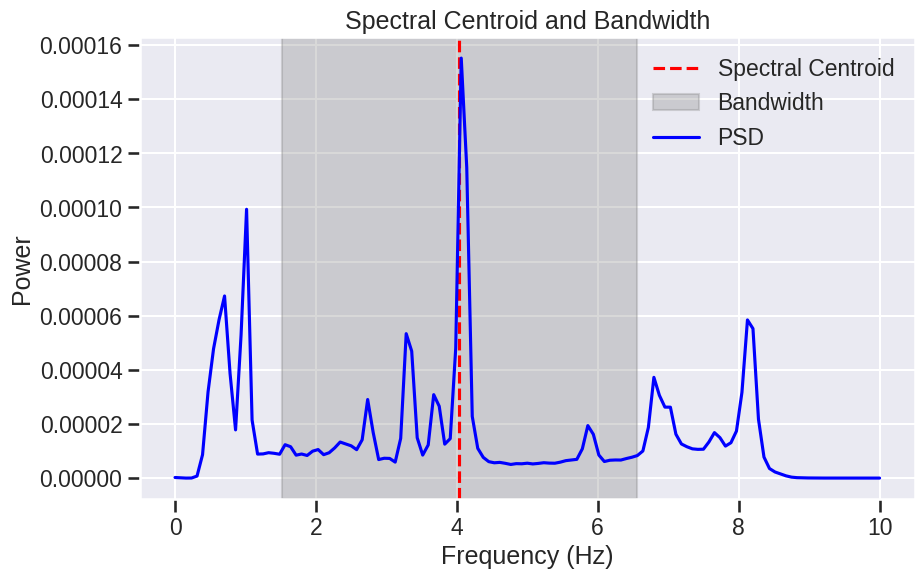

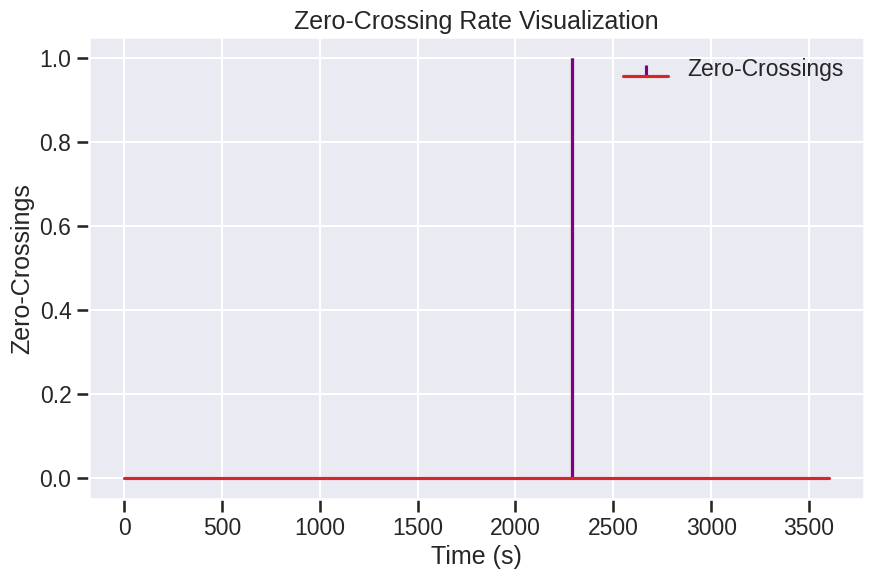

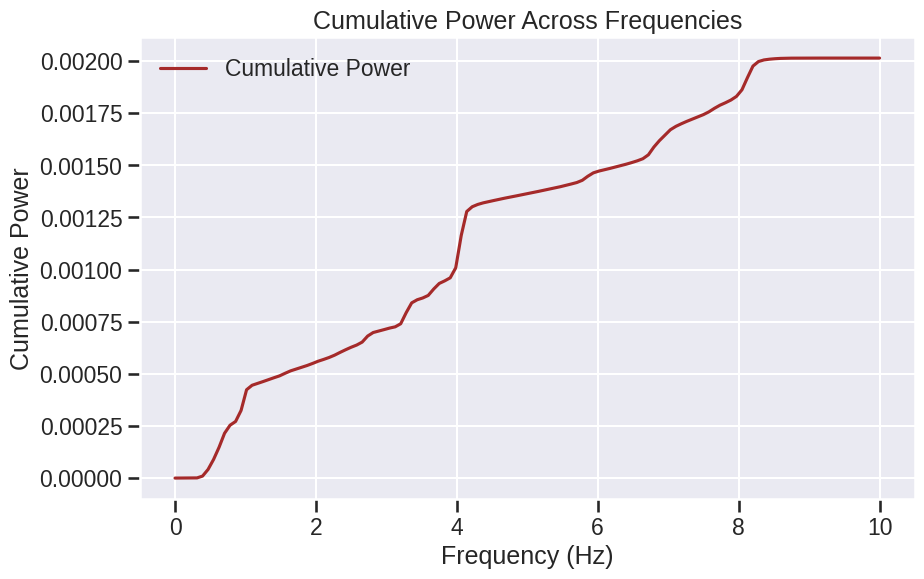

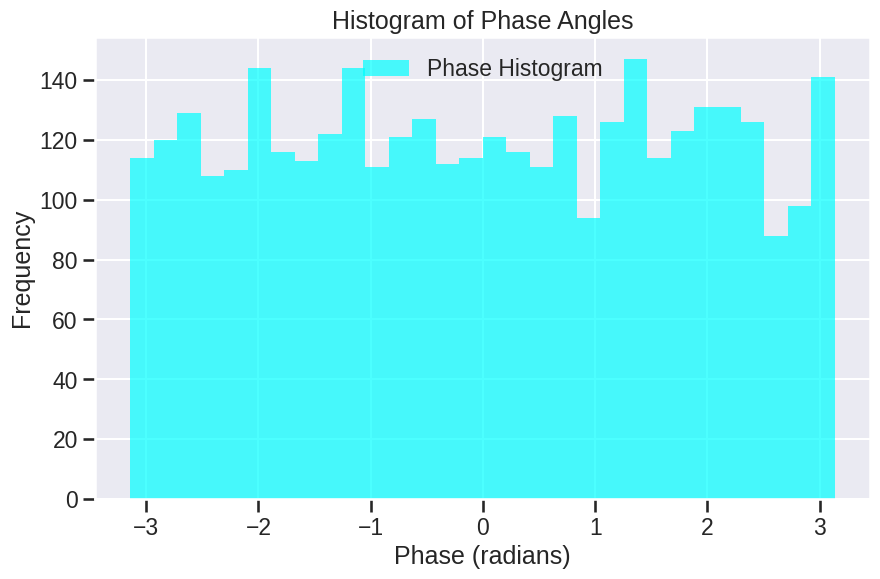

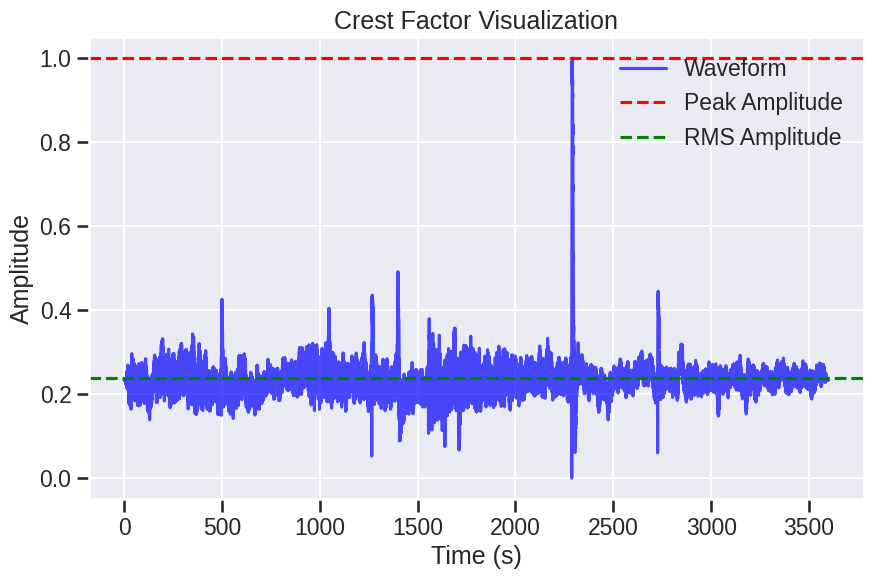

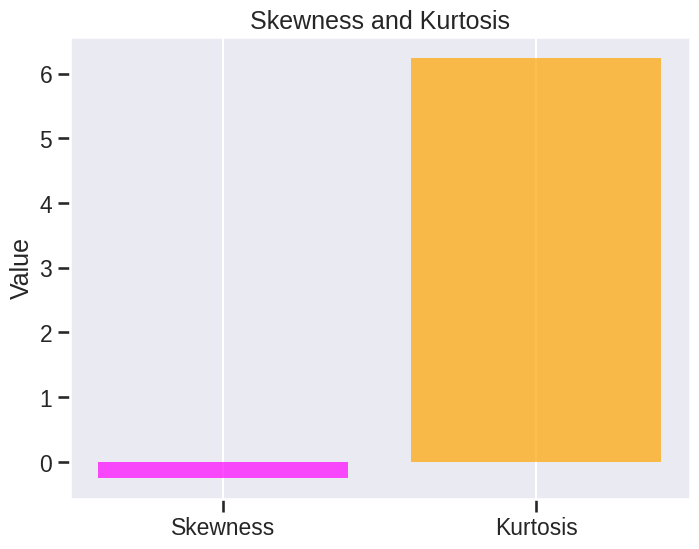

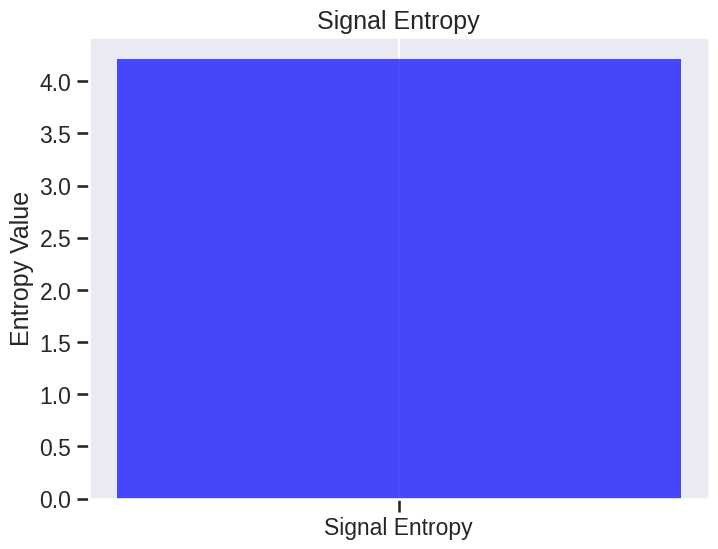

In [10]:


# Bandpass Filter with Correct Frequency Normalization
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Applies a bandpass filter to the seismic data.

    Args:
        data (array): Seismic waveform data.
        lowcut (float): Lower bound frequency (Hz).
        highcut (float): Upper bound frequency (Hz).
        fs (float): Sampling rate (Hz).
        order (int): Filter order.

    Returns:
        array: Filtered data.
    """
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = min(highcut / nyquist, 0.99)  # Ensure highcut is below 1.0

    # Ensure the frequencies are valid
    if not (0 < low < 1) or not (0 < high < 1):
        raise ValueError(f"Digital filter critical frequencies must be 0 < Wn < 1. Got low={low}, high={high}.")
    
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def extract_features_from_seismic(seismic_data, times, sampling_rate):
    # Preserve raw data for true amplitude calculations
    raw_data = seismic_data.copy()

    # -------------------- Preprocessing --------------------
    filtered_data = bandpass_filter(raw_data, lowcut=0.5, highcut=10, fs=sampling_rate)
    window = get_window('hamming', len(filtered_data))
    windowed_data = filtered_data * window

    # -------------------- Amplitude Features --------------------
    # True peak and RMS amplitude from raw data (un-normalized)
    true_peak_amplitude = np.max(np.abs(raw_data))
    true_rms_amplitude = np.sqrt(np.mean(raw_data ** 2))
    
    # Filtered peak and RMS amplitude (for filtered waveform)
    peak_amplitude = np.max(np.abs(filtered_data))
    rms_amplitude = np.sqrt(np.mean(filtered_data ** 2))
    crest_factor = peak_amplitude / rms_amplitude

    # -------------------- Statistical Features --------------------
    zcr = np.mean(np.diff(np.sign(filtered_data)) != 0)  # Zero-Crossing Rate
    skewness = skew(filtered_data)
    kurt = kurtosis(filtered_data)

    # -------------------- Frequency Features --------------------
    n = len(windowed_data)
    fft_vals = fft(windowed_data)
    freqs = np.fft.fftfreq(n, d=1 / sampling_rate)
    positive_freqs = freqs[:n // 2]
    positive_fft_vals = np.abs(fft_vals[:n // 2])
    dominant_frequency = positive_freqs[np.argmax(positive_fft_vals)]

    f_psd, psd = welch(filtered_data, fs=sampling_rate)
    spectral_centroid = np.sum(f_psd * psd) / np.sum(psd)
    bandwidth = np.sqrt(np.sum(((f_psd - spectral_centroid) ** 2) * psd) / np.sum(psd))
    total_power = np.sum(psd)
    peak_frequency = f_psd[np.argmax(psd)]

    # -------------------- Phase Spectrum --------------------
    phase_spectrum = np.angle(fft_vals[:n // 2])
    significant_indices = positive_fft_vals > np.percentile(positive_fft_vals, 90)
    significant_freqs = positive_freqs[significant_indices]
    significant_phases = phase_spectrum[significant_indices]

    # -------------------- Signal Entropy --------------------
    norm_psd = psd / np.sum(psd)  # Normalize PSD for entropy calculation
    signal_entropy = entropy(norm_psd)

    # -------------------- Return Features --------------------
    features = {
        "True Peak Amplitude": true_peak_amplitude,
        "True RMS Amplitude": true_rms_amplitude,
        "Filtered Peak Amplitude": peak_amplitude,
        "Filtered RMS Amplitude": rms_amplitude,
        "Crest Factor": crest_factor,
        "Zero-Crossing Rate": zcr,
        "Skewness": skewness,
        "Kurtosis": kurt,
        "Dominant Frequency": dominant_frequency,
        "Spectral Centroid": spectral_centroid,
        "Bandwidth": bandwidth,
        "Total Power": total_power,
        "Peak Frequency": peak_frequency,
        "Signal Entropy": signal_entropy,
        "Phase Spectrum": significant_phases,
        "Significant Frequencies": significant_freqs,
        "PSD Frequencies": f_psd,
        "PSD Values": psd,
    }
    return features


# -------------------- Load and Normalize Seismic Data --------------------
stream = read(file_path)
trace = stream[0]
seismic_data = trace.data
times = trace.times()

# Normalize the data
seismic_data = (seismic_data - seismic_data.min()) / (seismic_data.max() - seismic_data.min())
sampling_rate = 1 / (times[1] - times[0])

# Extract features
features = extract_features_from_seismic(seismic_data, times, sampling_rate)

# -------------------- Display Features --------------------
print("Extracted Features:")
for key, value in features.items():
    if isinstance(value, (float, int)):  # Print scalar features only
        print(f"{key}: {value}")

# -------------------- Graphical Visualizations --------------------
# Original Waveform
plt.figure(figsize=(10, 6))
plt.plot(times, seismic_data, label="Original Waveform")
plt.title("Original Seismic Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

# Histogram of Amplitudes
plt.figure(figsize=(10, 6))
plt.hist(seismic_data, bins=30, color="blue", alpha=0.7, label="Amplitude Histogram")
plt.title("Histogram of Seismic Amplitudes")
plt.xlabel("Amplitude")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# Power Spectral Density (PSD)
plt.figure(figsize=(10, 6))
plt.plot(features['PSD Frequencies'], features['PSD Values'], label="PSD", color="orange")
plt.title("Power Spectral Density (PSD)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.legend()
plt.grid(True)
plt.show()

# Phase Spectrum
plt.figure(figsize=(10, 6))
plt.scatter(features["Significant Frequencies"], features["Phase Spectrum"], color='green', alpha=0.6)
plt.title("Phase Spectrum (Significant Frequencies)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (radians)")
plt.grid(True)
plt.show()

# Spectral Centroid and Bandwidth
plt.figure(figsize=(10, 6))
plt.axvline(features["Spectral Centroid"], color='red', linestyle='--', label="Spectral Centroid")
plt.axvspan(features["Spectral Centroid"] - features["Bandwidth"], features["Spectral Centroid"] + features["Bandwidth"],
            color='gray', alpha=0.3, label="Bandwidth")
plt.plot(features['PSD Frequencies'], features['PSD Values'], label="PSD", color="blue")
plt.title("Spectral Centroid and Bandwidth")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.legend()
plt.grid(True)
plt.show()

# Zero-Crossing Rate Visualization
plt.figure(figsize=(10, 6))
zcr_times = times[:-1]
zcr_values = np.diff(np.sign(seismic_data)) != 0
plt.stem(zcr_times, zcr_values, label="Zero-Crossings", linefmt="purple", markerfmt=" ")
plt.title("Zero-Crossing Rate Visualization")
plt.xlabel("Time (s)")
plt.ylabel("Zero-Crossings")
plt.legend()
plt.grid(True)
plt.show()

# Cumulative Power
plt.figure(figsize=(10, 6))
cumulative_power = np.cumsum(features["PSD Values"])
plt.plot(features['PSD Frequencies'], cumulative_power, label="Cumulative Power", color="brown")
plt.title("Cumulative Power Across Frequencies")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Cumulative Power")
plt.legend()
plt.grid(True)
plt.show()

# Histogram of Phase Angles
plt.figure(figsize=(10, 6))
plt.hist(features["Phase Spectrum"], bins=30, color="cyan", alpha=0.7, label="Phase Histogram")
plt.title("Histogram of Phase Angles")
plt.xlabel("Phase (radians)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# Crest Factor Visualization
plt.figure(figsize=(10, 6))
plt.plot(times, seismic_data, label="Waveform", color="blue", alpha=0.7)
plt.axhline(features["True Peak Amplitude"], color='red', linestyle='--', label="Peak Amplitude")
plt.axhline(features["True RMS Amplitude"], color='green', linestyle='--', label="RMS Amplitude")
plt.title("Crest Factor Visualization")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

# Skewness and Kurtosis Bar Plot
plt.figure(figsize=(8, 6))
plt.bar(["Skewness", "Kurtosis"], [features["Skewness"], features["Kurtosis"]], color=["magenta", "orange"], alpha=0.7)
plt.title("Skewness and Kurtosis")
plt.ylabel("Value")
plt.grid(axis='y')
plt.show()

# Signal Entropy Visualization
plt.figure(figsize=(8, 6))
plt.bar(["Signal Entropy"], [features["Signal Entropy"]], color="blue", alpha=0.7)
plt.title("Signal Entropy")
plt.ylabel("Entropy Value")
plt.grid(axis='y')
plt.show()


In [11]:
file_path="/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/mars/test/data/XB.ELYSE.02.BHV.2019-07-26HR12_evid0033.mseed"

Extracted Features:
True Peak Amplitude: 1.0
True RMS Amplitude: 0.43026696818025484
Filtered Peak Amplitude: 0.10380629547858472
Filtered RMS Amplitude: 0.006190914953739841
Crest Factor: 16.767520835652387
Zero-Crossing Rate: 0.39838053306295923
Skewness: -0.0858603262803313
Kurtosis: 8.29266358159527
Dominant Frequency: 1.0
Spectral Centroid: 3.5110438883165824
Bandwidth: 2.6428902909130563
Total Power: 0.000500120647474711
Peak Frequency: 1.015625
Signal Entropy: 4.0945995752653115


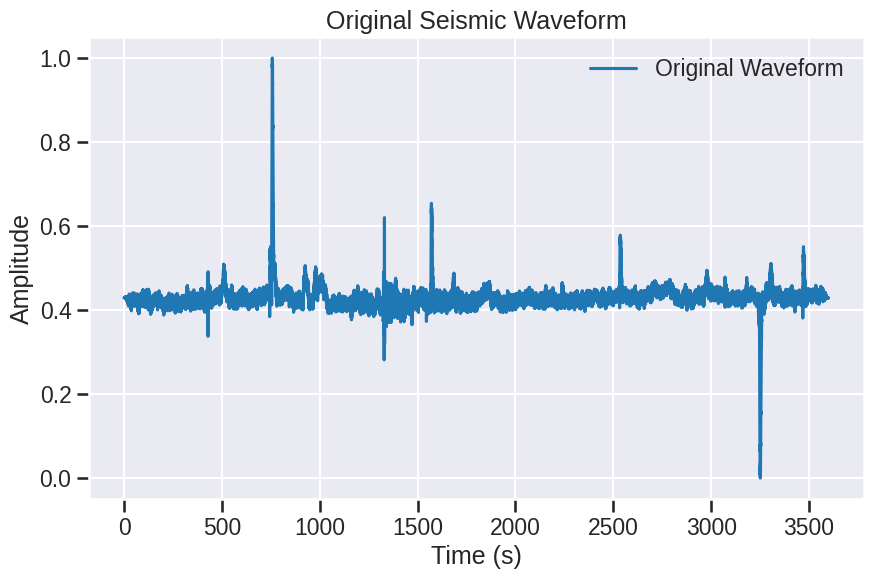

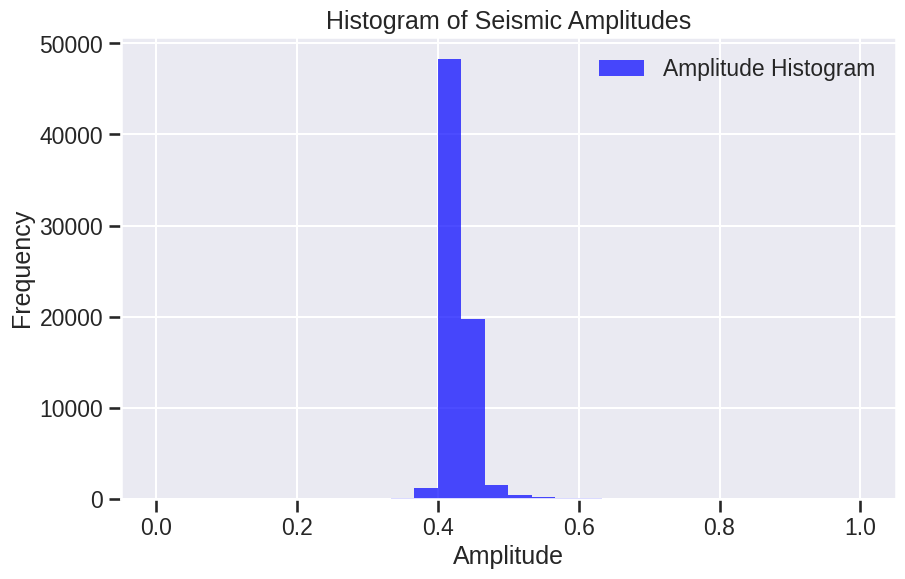

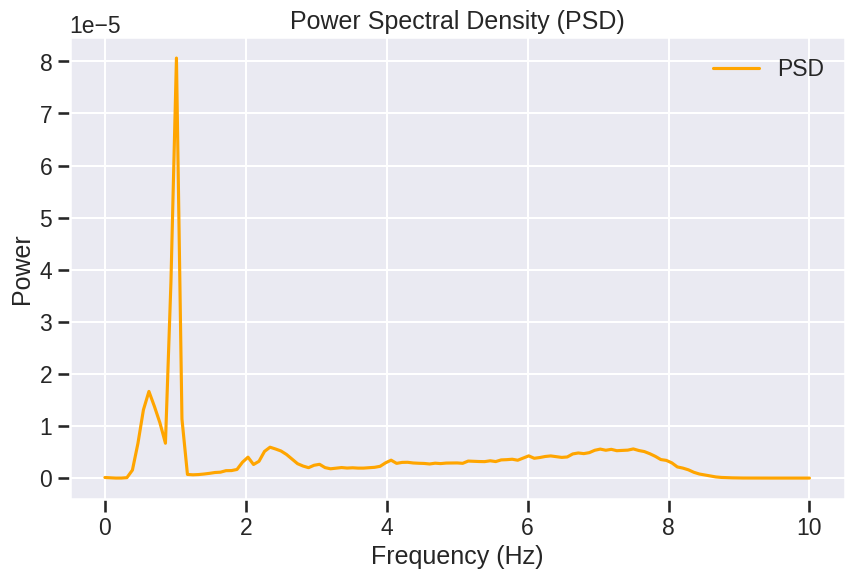

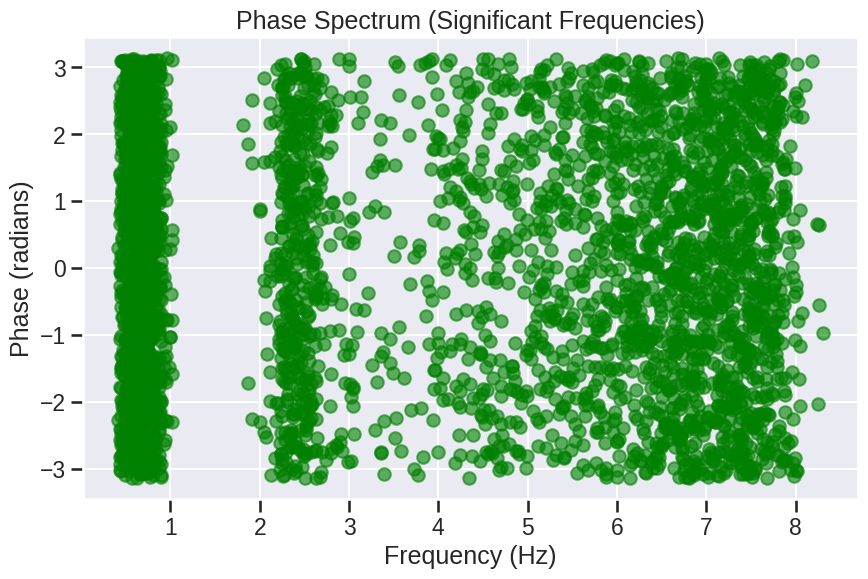

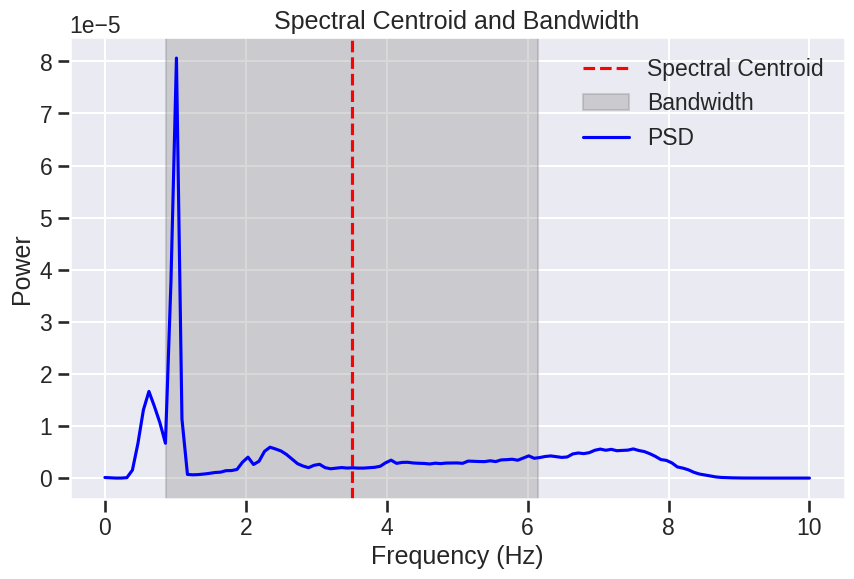

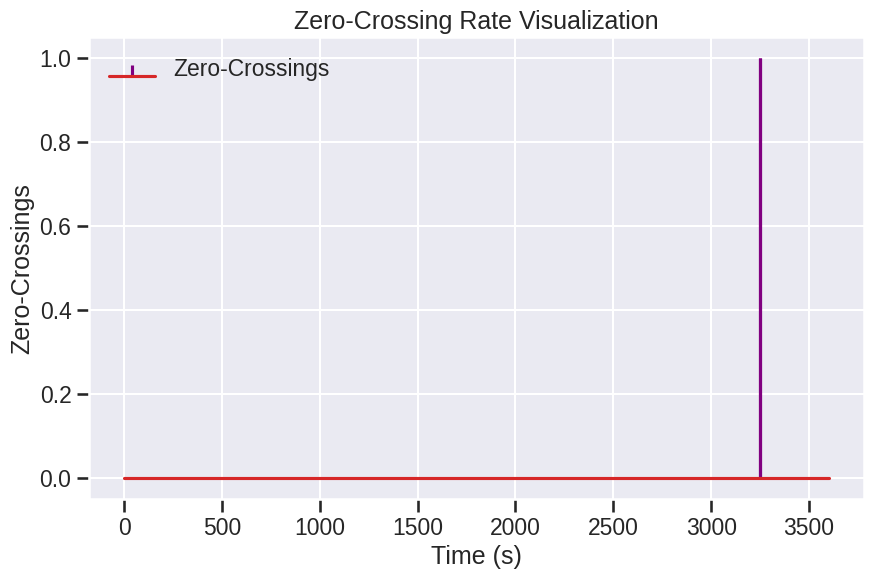

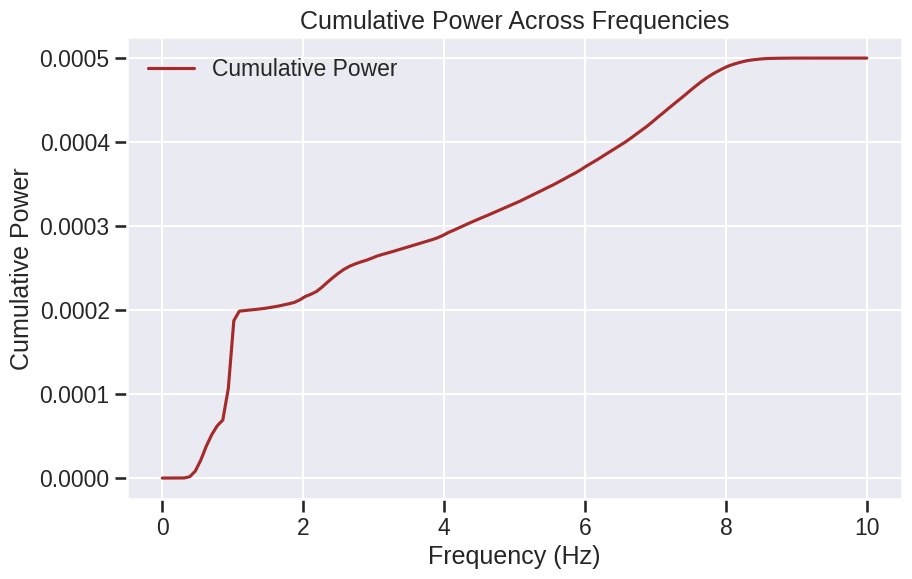

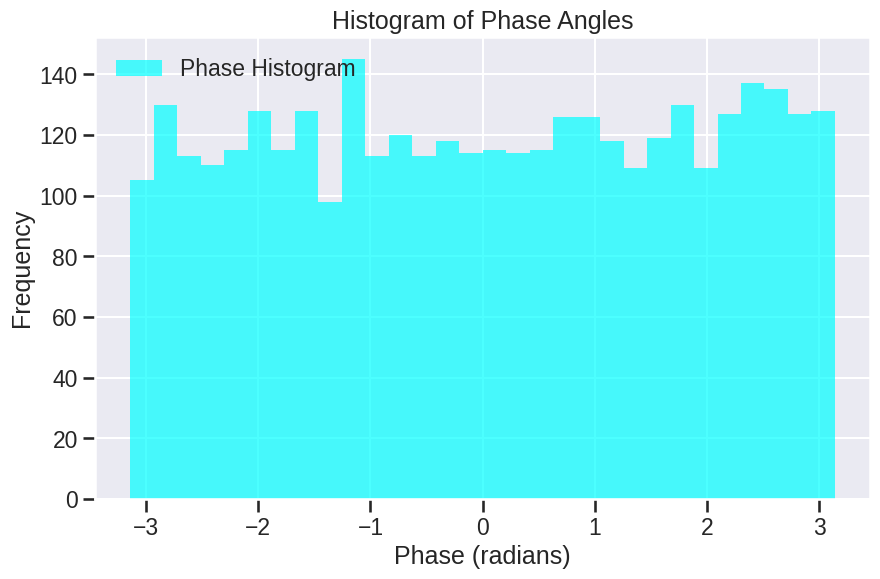

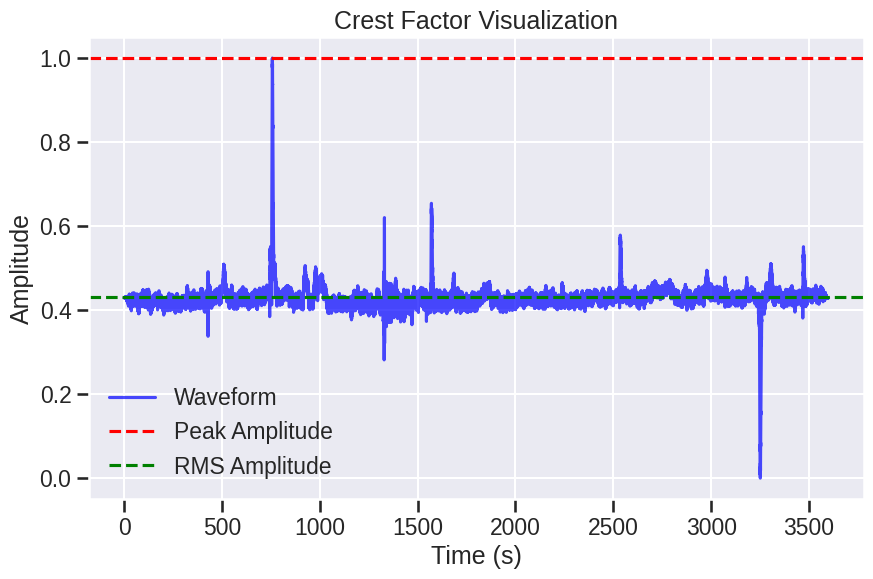

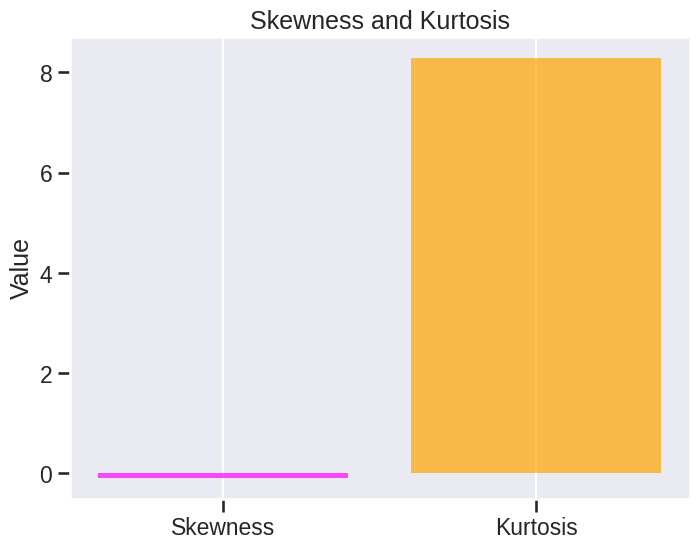

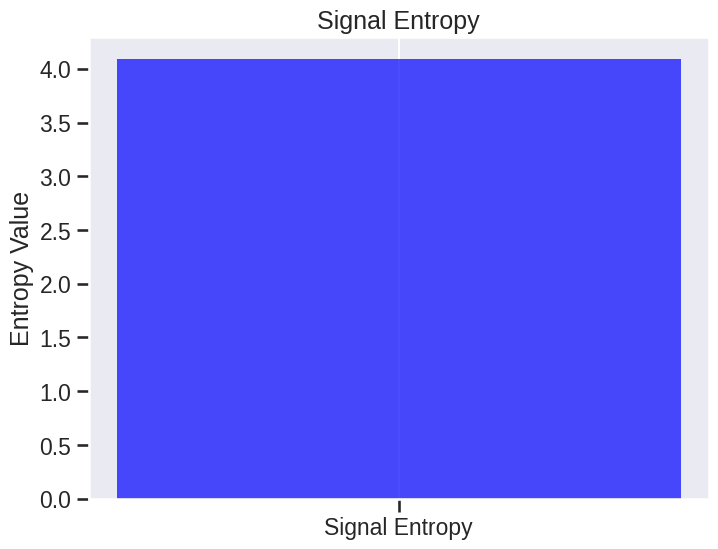

In [12]:


# Bandpass Filter with Correct Frequency Normalization
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Applies a bandpass filter to the seismic data.

    Args:
        data (array): Seismic waveform data.
        lowcut (float): Lower bound frequency (Hz).
        highcut (float): Upper bound frequency (Hz).
        fs (float): Sampling rate (Hz).
        order (int): Filter order.

    Returns:
        array: Filtered data.
    """
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = min(highcut / nyquist, 0.99)  # Ensure highcut is below 1.0

    # Ensure the frequencies are valid
    if not (0 < low < 1) or not (0 < high < 1):
        raise ValueError(f"Digital filter critical frequencies must be 0 < Wn < 1. Got low={low}, high={high}.")
    
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def extract_features_from_seismic(seismic_data, times, sampling_rate):
    # Preserve raw data for true amplitude calculations
    raw_data = seismic_data.copy()

    # -------------------- Preprocessing --------------------
    filtered_data = bandpass_filter(raw_data, lowcut=0.5, highcut=10, fs=sampling_rate)
    window = get_window('hamming', len(filtered_data))
    windowed_data = filtered_data * window

    # -------------------- Amplitude Features --------------------
    # True peak and RMS amplitude from raw data (un-normalized)
    true_peak_amplitude = np.max(np.abs(raw_data))
    true_rms_amplitude = np.sqrt(np.mean(raw_data ** 2))
    
    # Filtered peak and RMS amplitude (for filtered waveform)
    peak_amplitude = np.max(np.abs(filtered_data))
    rms_amplitude = np.sqrt(np.mean(filtered_data ** 2))
    crest_factor = peak_amplitude / rms_amplitude

    # -------------------- Statistical Features --------------------
    zcr = np.mean(np.diff(np.sign(filtered_data)) != 0)  # Zero-Crossing Rate
    skewness = skew(filtered_data)
    kurt = kurtosis(filtered_data)

    # -------------------- Frequency Features --------------------
    n = len(windowed_data)
    fft_vals = fft(windowed_data)
    freqs = np.fft.fftfreq(n, d=1 / sampling_rate)
    positive_freqs = freqs[:n // 2]
    positive_fft_vals = np.abs(fft_vals[:n // 2])
    dominant_frequency = positive_freqs[np.argmax(positive_fft_vals)]

    f_psd, psd = welch(filtered_data, fs=sampling_rate)
    spectral_centroid = np.sum(f_psd * psd) / np.sum(psd)
    bandwidth = np.sqrt(np.sum(((f_psd - spectral_centroid) ** 2) * psd) / np.sum(psd))
    total_power = np.sum(psd)
    peak_frequency = f_psd[np.argmax(psd)]

    # -------------------- Phase Spectrum --------------------
    phase_spectrum = np.angle(fft_vals[:n // 2])
    significant_indices = positive_fft_vals > np.percentile(positive_fft_vals, 90)
    significant_freqs = positive_freqs[significant_indices]
    significant_phases = phase_spectrum[significant_indices]

    # -------------------- Signal Entropy --------------------
    norm_psd = psd / np.sum(psd)  # Normalize PSD for entropy calculation
    signal_entropy = entropy(norm_psd)

    # -------------------- Return Features --------------------
    features = {
        "True Peak Amplitude": true_peak_amplitude,
        "True RMS Amplitude": true_rms_amplitude,
        "Filtered Peak Amplitude": peak_amplitude,
        "Filtered RMS Amplitude": rms_amplitude,
        "Crest Factor": crest_factor,
        "Zero-Crossing Rate": zcr,
        "Skewness": skewness,
        "Kurtosis": kurt,
        "Dominant Frequency": dominant_frequency,
        "Spectral Centroid": spectral_centroid,
        "Bandwidth": bandwidth,
        "Total Power": total_power,
        "Peak Frequency": peak_frequency,
        "Signal Entropy": signal_entropy,
        "Phase Spectrum": significant_phases,
        "Significant Frequencies": significant_freqs,
        "PSD Frequencies": f_psd,
        "PSD Values": psd,
    }
    return features


# -------------------- Load and Normalize Seismic Data --------------------
stream = read(file_path)
trace = stream[0]
seismic_data = trace.data
times = trace.times()

# Normalize the data
seismic_data = (seismic_data - seismic_data.min()) / (seismic_data.max() - seismic_data.min())
sampling_rate = 1 / (times[1] - times[0])

# Extract features
features = extract_features_from_seismic(seismic_data, times, sampling_rate)

# -------------------- Display Features --------------------
print("Extracted Features:")
for key, value in features.items():
    if isinstance(value, (float, int)):  # Print scalar features only
        print(f"{key}: {value}")

# -------------------- Graphical Visualizations --------------------
# Original Waveform
plt.figure(figsize=(10, 6))
plt.plot(times, seismic_data, label="Original Waveform")
plt.title("Original Seismic Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

# Histogram of Amplitudes
plt.figure(figsize=(10, 6))
plt.hist(seismic_data, bins=30, color="blue", alpha=0.7, label="Amplitude Histogram")
plt.title("Histogram of Seismic Amplitudes")
plt.xlabel("Amplitude")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# Power Spectral Density (PSD)
plt.figure(figsize=(10, 6))
plt.plot(features['PSD Frequencies'], features['PSD Values'], label="PSD", color="orange")
plt.title("Power Spectral Density (PSD)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.legend()
plt.grid(True)
plt.show()

# Phase Spectrum
plt.figure(figsize=(10, 6))
plt.scatter(features["Significant Frequencies"], features["Phase Spectrum"], color='green', alpha=0.6)
plt.title("Phase Spectrum (Significant Frequencies)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (radians)")
plt.grid(True)
plt.show()

# Spectral Centroid and Bandwidth
plt.figure(figsize=(10, 6))
plt.axvline(features["Spectral Centroid"], color='red', linestyle='--', label="Spectral Centroid")
plt.axvspan(features["Spectral Centroid"] - features["Bandwidth"], features["Spectral Centroid"] + features["Bandwidth"],
            color='gray', alpha=0.3, label="Bandwidth")
plt.plot(features['PSD Frequencies'], features['PSD Values'], label="PSD", color="blue")
plt.title("Spectral Centroid and Bandwidth")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.legend()
plt.grid(True)
plt.show()

# Zero-Crossing Rate Visualization
plt.figure(figsize=(10, 6))
zcr_times = times[:-1]
zcr_values = np.diff(np.sign(seismic_data)) != 0
plt.stem(zcr_times, zcr_values, label="Zero-Crossings", linefmt="purple", markerfmt=" ")
plt.title("Zero-Crossing Rate Visualization")
plt.xlabel("Time (s)")
plt.ylabel("Zero-Crossings")
plt.legend()
plt.grid(True)
plt.show()

# Cumulative Power
plt.figure(figsize=(10, 6))
cumulative_power = np.cumsum(features["PSD Values"])
plt.plot(features['PSD Frequencies'], cumulative_power, label="Cumulative Power", color="brown")
plt.title("Cumulative Power Across Frequencies")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Cumulative Power")
plt.legend()
plt.grid(True)
plt.show()

# Histogram of Phase Angles
plt.figure(figsize=(10, 6))
plt.hist(features["Phase Spectrum"], bins=30, color="cyan", alpha=0.7, label="Phase Histogram")
plt.title("Histogram of Phase Angles")
plt.xlabel("Phase (radians)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# Crest Factor Visualization
plt.figure(figsize=(10, 6))
plt.plot(times, seismic_data, label="Waveform", color="blue", alpha=0.7)
plt.axhline(features["True Peak Amplitude"], color='red', linestyle='--', label="Peak Amplitude")
plt.axhline(features["True RMS Amplitude"], color='green', linestyle='--', label="RMS Amplitude")
plt.title("Crest Factor Visualization")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

# Skewness and Kurtosis Bar Plot
plt.figure(figsize=(8, 6))
plt.bar(["Skewness", "Kurtosis"], [features["Skewness"], features["Kurtosis"]], color=["magenta", "orange"], alpha=0.7)
plt.title("Skewness and Kurtosis")
plt.ylabel("Value")
plt.grid(axis='y')
plt.show()

# Signal Entropy Visualization
plt.figure(figsize=(8, 6))
plt.bar(["Signal Entropy"], [features["Signal Entropy"]], color="blue", alpha=0.7)
plt.title("Signal Entropy")
plt.ylabel("Entropy Value")
plt.grid(axis='y')
plt.show()


In [13]:
#If you want to see for all waves replace the file_path or redefine it